<center><img src="./images/logo_fmkn.png" width=300 style="display: inline-block;"></center> 

## Машинное обучение
### Семинар 10. Композиция моделей

<br />
<br />
11 ноября 2021

### Подготовка и первые эксперименты

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, 
                           n_redundant=5, random_state=42)

In [30]:
X.shape

(1000, 20)

In [39]:
pd.Series.value_counts(y)

0    502
1    498
dtype: int64

In [2]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

def eval_classifier(clf):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=43)
    n_scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return np.mean(n_scores), np.std(n_scores)

In [3]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

results_accuracy = pd.DataFrame(0.0,
                                columns=['No composition', 'Dummy', 'Bagging', 'Bagging_mf', 'AdaBoost'],
                                index=['DTC', 'DTC-1', 'LR', 'SVC'])

In [4]:
acc_mean, acc_std = eval_classifier(DecisionTreeClassifier())

results_accuracy.loc['DTC', 'No composition'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.80, 0.05


In [5]:
acc_mean, acc_std = eval_classifier(DecisionTreeClassifier(max_depth=1))

results_accuracy.loc['DTC-1', 'No composition'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.68, 0.04


In [6]:
acc_mean, acc_std = eval_classifier(LogisticRegression())

results_accuracy.loc['LR', 'No composition'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.81, 0.03


In [7]:
acc_mean, acc_std = eval_classifier(SVC(probability=True))

results_accuracy.loc['SVC', 'No composition'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.94, 0.02


### Dummy

Для начала реализуем свой простейший метод ассамблирования. 

Идея проста: мы будем просто обучать классификатор несколько раз и усреднять ответ: $$c(x) = \frac{1}{n}\sum\limits_{i=1}^n c_i(x)$$

In [8]:
from sklearn import base

class DummyEnsemble(object):
    def __init__(self, base_estimator, n_estimators=10):
        self.n_estimators = n_estimators
        self.base_estimator = base_estimator            
        self._bs = [base.clone(self.base_estimator) for _ in range(self.n_estimators)]
        
    def get_params(self, deep=True):
        return {'n_estimators': self.n_estimators, 
                'base_estimator': self.base_estimator}
        
    def fit(self, X, Y):
        for b in self._bs:
            b.fit(X, Y)
            
    def predict(self, X):
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)
    
    def predict_proba(self, X):
        return np.mean([b.predict_proba(X) for b in self._bs], axis=0)

In [9]:
acc_mean, acc_std = eval_classifier(DummyEnsemble(DecisionTreeClassifier(), n_estimators=10))

results_accuracy.loc['DTC', 'Dummy'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.79, 0.05


In [10]:
acc_mean, acc_std = eval_classifier(DummyEnsemble(DecisionTreeClassifier(max_depth=1)))

results_accuracy.loc['DTC-1', 'Dummy'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.68, 0.04


In [11]:
acc_mean, acc_std = eval_classifier(DummyEnsemble(LogisticRegression()))

results_accuracy.loc['LR', 'Dummy'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.81, 0.03


In [12]:
acc_mean, acc_std = eval_classifier(DummyEnsemble(SVC(probability=True)))

results_accuracy.loc['SVC', 'Dummy'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.94, 0.02


<div class="alert alert-info">
<b>Вопрос 1:</b> Какие проблемы у данного метода?
</div>

In [13]:
pd.options.display.float_format = "{:,.2f}".format
results_accuracy

,No composition,Dummy,Bagging,Bagging_mf,AdaBoost
DTC,0.80,0.79,0.00,0.00,0.00
DTC-1,0.68,0.68,0.00,0.00,0.00
LR,0.81,0.81,0.00,0.00,0.00
SVC,0.94,0.94,0.00,0.00,0.00


### Bagging

Естественная модификация метода из предыдущего пункта — Bagging. В нём для обучения каждой следующей модели используем только часть данных/признаков.

In [2]:
from sklearn.ensemble import BaggingClassifier

In [15]:

acc_mean, acc_std = eval_classifier(
    BaggingClassifier(DecisionTreeClassifier(), n_estimators=10, 
                      max_samples=1.0, max_features=1.0, 
                      bootstrap=True, bootstrap_features=False))

results_accuracy.loc['DTC', 'Bagging'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.87, 0.04


In [16]:
acc_mean, acc_std = eval_classifier(
    BaggingClassifier(DecisionTreeClassifier(), n_estimators=10, 
                      max_samples=1.0, max_features=0.8, 
                      bootstrap=True, bootstrap_features=False))

results_accuracy.loc['DTC', 'Bagging_mf'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.87, 0.04


In [17]:
from sklearn.ensemble import BaggingClassifier

acc_mean, acc_std = eval_classifier(
    BaggingClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=10, 
                      max_samples=1.0, max_features=1.0, 
                      bootstrap=True, bootstrap_features=False))

results_accuracy.loc['DTC-1', 'Bagging'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.68, 0.04


In [18]:
from sklearn.ensemble import BaggingClassifier

acc_mean, acc_std = eval_classifier(
    BaggingClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=10, 
                      max_samples=1.0, max_features=0.8, 
                      bootstrap=True, bootstrap_features=False))

results_accuracy.loc['DTC-1', 'Bagging_mf'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.69, 0.04


In [19]:
acc_mean, acc_std = eval_classifier(
    BaggingClassifier(LogisticRegression(), n_estimators=10, 
                      max_samples=1.0, max_features=1.0, 
                      bootstrap=True, bootstrap_features=False))

results_accuracy.loc['LR', 'Bagging'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.81, 0.04


In [20]:
acc_mean, acc_std = eval_classifier(
    BaggingClassifier(LogisticRegression(), n_estimators=10, 
                      max_samples=1.0, max_features=0.8, 
                      bootstrap=True, bootstrap_features=False))

results_accuracy.loc['LR', 'Bagging_mf'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.81, 0.04


In [21]:
acc_mean, acc_std = eval_classifier(BaggingClassifier(SVC(probability=True)))

results_accuracy.loc['SVC', 'Bagging'] = acc_mean
print(f"{acc_mean:.3f}, {acc_std:.3f}")

0.937, 0.022


In [22]:
acc_mean, acc_std = eval_classifier(
    BaggingClassifier(SVC(probability=True), n_estimators=10, 
                      max_samples=1.0, max_features=0.8, 
                      bootstrap=True, bootstrap_features=False))

results_accuracy.loc['SVC', 'Bagging_mf'] = acc_mean
print(f"{acc_mean:.3f}, {acc_std:.3f}")

0.937, 0.022


<div class="alert alert-info">
<b>Вопрос 2:</b> Какие плюсы/минусы у Bagging'а по сравнению с Dummy методом?
</div>

In [23]:
results_accuracy

,No composition,Dummy,Bagging,Bagging_mf,AdaBoost
DTC,0.80,0.79,0.87,0.87,0.00
DTC-1,0.68,0.68,0.68,0.69,0.00
LR,0.81,0.81,0.81,0.81,0.00
SVC,0.94,0.94,0.94,0.94,0.00


### AdaBoost

AdaBoost обучает каждый следующий классификатор на объектах, на которых ошибаются предыдущие (объекты с ошибками получают больший вес, без ошибок — меньший).

In [3]:
from sklearn.ensemble import AdaBoostClassifier

In [25]:
acc_mean, acc_std = eval_classifier(
    AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=50, learning_rate=1.0))

results_accuracy.loc['DTC', 'AdaBoost'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.79, 0.05


In [26]:
acc_mean, acc_std = eval_classifier(
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=1)))

results_accuracy.loc['DTC-1', 'AdaBoost'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.82, 0.04


In [27]:
acc_mean, acc_std = eval_classifier(
    AdaBoostClassifier(LogisticRegression()))

results_accuracy.loc['LR', 'AdaBoost'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.82, 0.04


In [28]:
acc_mean, acc_std = eval_classifier(
    AdaBoostClassifier(SVC(probability=True)))

results_accuracy.loc['SVC', 'AdaBoost'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.95, 0.02


In [29]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

results_to_show = results_accuracy.copy()

results_to_show.style.apply(highlight_max, props='color:white;background-color:green;', axis=1).format('{:.3f}')

,No composition,Dummy,Bagging,Bagging_mf,AdaBoost
DTC,0.795,0.794,0.866,0.875,0.788
DTC-1,0.683,0.683,0.684,0.685,0.818
LR,0.811,0.811,0.813,0.813,0.815
SVC,0.938,0.942,0.937,0.937,0.953


<div class="alert alert-info">
<b>Вопрос 3:</b> Ни бэггинг, ни бустинг не дали заметного улучшения для логистической регрессии. Объясните, почему.
</div>

<div class="alert alert-info">
<b>Вопрос 4:</b> Почему AdaBoost хуже работает на глубоких деревьях?
</div>

<div class="alert alert-info">
<b>Вопрос 5:</b> В чем минусы использвоания AdaBoost + SVC?
</div>

# GradBoost

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

acc_mean, acc_std = eval_classifier(GradientBoostingClassifier())

sk_gboost = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.90, 0.04


# XGBoost

[Статья](https://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf)

Плюсы:
* Хорошая [документация](https://xgboost.readthedocs.io/en/latest/)
* Позволяет легко паралелить вычисления (например на спарке)
* Легко использовать с sklearn и numpy (но с потерей производительности)
* Обработка разреженных данных
* Предсортированные блоки, кэши, шардирование

Минусы:
* Нет поддержки GPU

In [41]:
import xgboost

acc_mean, acc_std = eval_classifier(xgboost.XGBClassifier(objective='binary:logistic', random_state=42))

xg_boost = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.92, 0.04


# LightGBM

[Статья](https://papers.nips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)

Плюсы:
* Хорошая [документация](https://lightgbm.readthedocs.io/en/latest/Python-API.html)
* Поддержка GPU
* Метод Фишера для работы с категориальными признаками
* Уменьшение размера обучающей выборки (GOSS)
* Объединение разреженных признаков (EFB)

Минусы:
* Майкрософт как всегда пошли своим путем и итерфейс не совместим с sklearn/numpy

In [42]:
import lightgbm as lgb

train_data = lgb.Dataset(X, label=y)

param = {'num_leaves': 31, 
         'objective': 'multiclass', 
         'num_class': 2, 
         'metric': ['multi_logloss']}

num_round = 10
boost = lgb.train(param, train_data, num_boost_round=10)

lg_boost = (boost.predict(X).argmax(axis=-1) == y).mean()

print(f"{lg_boost:.2f}")

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 20
[LightGBM] [Info] Start training from score -0.689155
[LightGBM] [Info] Start training from score -0.697155
0.95


# CatBoost

[Статья](https://papers.nips.cc/paper/2018/file/14491b756b3a51daac41c24863285549-Paper.pdf)

Плюсы:
* Хорошая [документация](https://catboost.ai/docs/concepts/python-quickstart.html)
* Поддержка GPU
* Легко использовать с sklearn и numpy
* Более продвинутая работа с категориальными фичами
* Можно поразрабатывать в Санкт-Петербурге

Минусы:
* Бывает работает хуже (возможно слабее эвристики), но с категориальными фичами — хорошо

In [43]:
from catboost import CatBoostClassifier

acc_mean, acc_std = eval_classifier(
    CatBoostClassifier(
        iterations=10,
        depth=2,
        learning_rate=1,
        loss_function='Logloss',
        verbose=True, 
        task_type='CPU'))

сat_boost = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.80, 0.04


In [44]:
results_to_show

,No composition,Dummy,Bagging,Bagging_mf,AdaBoost
DTC,0.80,0.79,0.87,0.87,0.79
DTC-1,0.68,0.68,0.68,0.69,0.82
LR,0.81,0.81,0.81,0.81,0.82
SVC,0.94,0.94,0.94,0.94,0.95


In [45]:
f"{sk_gboost:.2f}, {xg_boost:.2f}, {lg_boost:.2f}, {сat_boost:.2f}"

'0.90, 0.92, 0.95, 0.80'

# Случайный лес (Random forest)

In [46]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

In [47]:
data = load_wine()
X = data['data']
Y = data['target']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=30, 
                                                    random_state=0)

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(n_estimators=6, max_depth=2, random_state=0)
model.fit(X_train, Y_train)

print(model.score(X_train, Y_train), model.score(X_test, Y_test))
print(classification_report(Y_test, model.predict(X_test)))

0.9797297297297297 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.93      0.97        15
           2       0.86      1.00      0.92         6

    accuracy                           0.97        30
   macro avg       0.95      0.98      0.96        30
weighted avg       0.97      0.97      0.97        30



# Зависимость от числа деревьев

In [49]:
models = []
scores_train = []
scores_test = []
n_estimators = list(range(1, 20))
for estimators in n_estimators:
    model = RandomForestClassifier(n_estimators=estimators, random_state=0)
    model.fit(X_train, Y_train)
    models.append(model)
    scores_test.append(model.score(X_test, Y_test))
    scores_train.append(model.score(X_train, Y_train))

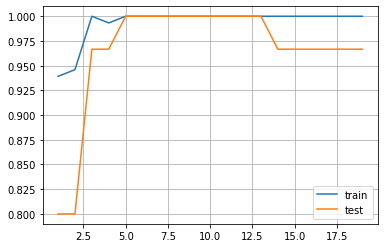

In [50]:
import matplotlib.pyplot as plt

plt.plot(n_estimators, scores_train, label='train')
plt.plot(n_estimators, scores_test, label='test')

plt.legend(loc='best')
plt.grid()
plt.show()

# Зависимость от числа признаков

In [51]:
models = []
scores_train = []
scores_test = []
max_features = list(range(1, 13))
for features in max_features:
    model = RandomForestClassifier(n_estimators=6, 
                                   max_features=features, random_state=0)
    model.fit(X_train, Y_train)
    models.append(model)
    scores_test.append(model.score(X_test, Y_test))
    scores_train.append(model.score(X_train, Y_train))

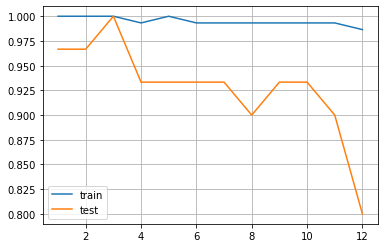

In [52]:
plt.plot(max_features, scores_train, label='train')
plt.plot(max_features, scores_test, label='test')

plt.legend(loc='best')
plt.grid()
plt.show()

# Зависимость от глубины

In [53]:
models = []
scores_train = []
scores_test = []
current_depth = []
max_depth = list(range(1, 10))
for depth in max_depth:
    model = RandomForestClassifier(n_estimators=6,
        max_depth=depth, random_state=0)
    model.fit(X_train, Y_train)
    models.append(model)
    scores_test.append(model.score(X_test, Y_test))
    scores_train.append(model.score(X_train, Y_train))
    current_depth.append(model.estimators_[0].get_depth()/depth)

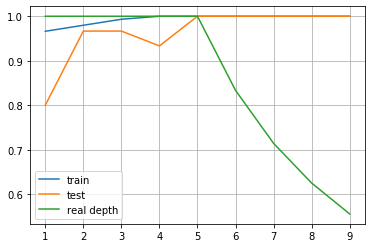

In [54]:
plt.plot(max_depth, scores_train, label='train')
plt.plot(max_depth, scores_test, label='test')
plt.plot(max_depth, current_depth, label='real depth')

plt.legend(loc='best')
plt.grid()
plt.show()

In [55]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=42)

In [56]:
acc_mean, acc_std = eval_classifier(RandomForestClassifier(n_estimators=10, max_depth=5, max_features=3, random_state=0))

print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.83, 0.04
